<a href="https://colab.research.google.com/github/ronykroy/DNN-NLP-and-other-stuff/blob/master/UlmFit_newsGroup3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# 3is the base line 4 is deeper training
# based on https://github.com/fastai/course-v3/blob/master/nbs/dl1/lesson3-imdb.ipynb
# but usgin newsgroups data...

In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [0]:
import fastai
from fastai import *
from fastai.text import * 
import pandas as pd
import numpy as np
from functools import partial
import io
import os

In [0]:
from sklearn.datasets import fetch_20newsgroups
dataset = fetch_20newsgroups(shuffle=True, random_state=1, remove=('headers', 'footers', 'quotes'))
documents = dataset.data

In [83]:
type(documents)

list

In [0]:
df = pd.DataFrame({'label':dataset.target, 'text':dataset.data})

In [85]:
df.shape

(11314, 2)

In [0]:
df.dropna(inplace=True)

In [87]:
df.shape

(11314, 2)

In [0]:
path_d  = pathlib.PosixPath('/sample_data2')

In [89]:
os.path.exists(path_d)

True

In [90]:
path_d

PosixPath('/sample_data2')

In [0]:
if not os.path.exists(path_d):
    os.mkdir(path_d) # if the path doesnt exist make it...

In [92]:
path_d/'texts.csv'

PosixPath('/sample_data2/texts.csv')

In [0]:
df.rename({'label':'target','text':text},inplace=True)

In [0]:
df.to_csv(path_d/'texts.csv',index=False)

In [0]:
bs=16# reduced from 48

In [0]:
# path

In [0]:
from sklearn.model_selection import train_test_split
df_trn, df_val = train_test_split(df, stratify = df['label'], test_size = 0.4, random_state = 12) # test_size is name sake
# test train split gives you just that test and train
# use twice.. 2nd time on train to get a separate test nd val set...

In [0]:
data_lm = TextLMDataBunch.from_df(train_df = df_trn, valid_df = df_val, path = path_d)

In [99]:
data_lm.save( path_d/'data_lm.pkl') # saving as a back stop

/usr/local/lib/python3.6/dist-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type CrossEntropyLoss. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [100]:
ls /sample_data2/

data_lm.pkl  models/  texts.csv


In [0]:
data_lm = load_data( '/sample_data2','data_lm.pkl', bs=bs) # jesus... give the path and the file in to which this was saved earlier.. 

In [102]:
data_lm.show_batch()

idx,text
0,"abuse "" and such , or course . \n xxmaj nobody seems to have noticed that the xxmaj treasury department has nothing \n to do with sex crimes . xxmaj or maybe the feds have recently instituted a \n xxup tax on sex crimes ... xxmaj yeah , that 's why the xxup batf was there , looking for \n unregistered * guns * ( """
1,"forward essentially . \n \t \n \t xxmaj but in terms of what is coming out of this weekend , \n i do n't yet know . xxmaj in a couple hours we 'll know . \n \t \n \t q ? \t xxmaj just a follow - up on the financing here . xxmaj is \n any of this robbing xxmaj peter to pay"
2,"have helped a little \n and good luck with the _ xxmaj oxygen sensor _ ? \n \n \t\t\t\t - xxmaj thomas - xxbos xxmaj for those of you interested , i just finished talking with a \n representative of xxmaj senator xxmaj bob xxmaj krueger 's xxunk campaign about his \n position on the xxup rtkba . xxmaj krueger was appointed by the xxmaj democratic xxmaj"
3,"project on xxunk performance , and have a \n wealth of data on particle size and output which we are going to use \n to xxunk a contract next week . \n \n xxmaj although the output data is easy for us to present , there seems to be \n little concensus on the optimum diameter of the xxunk droplets for \n straightforward inhalation therapy"
4,"- 870 - 0300 ) include a multi - font xxup xxunk document composer ; for several \n systems . \n \n \t arbortext , xxmaj inc. provides an xxup x11 version of its xxmaj electronic xxmaj publishing \n program called "" xxmaj the xxmaj publisher "" . xxmaj the xxmaj publisher is available on xxmaj sun , xxup hp and \n xxmaj apollo workstations . xxmaj"


In [0]:
learn = language_model_learner(data_lm, AWD_LSTM, drop_mult=0.7) # was 0.3
# drop_mult ::hyper-parameter 
# used for regularization, sets the amount of dropout{duh}
#If the model is over-fitting increase it, if under-fitting, you can decrease the number{again duh} but just a reminder if you are confounded by it again
# source:: https://www.analyticsvidhya.com/blog/2018/11/tutorial-text-classification-ulmfit-fastai-library/

In [104]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


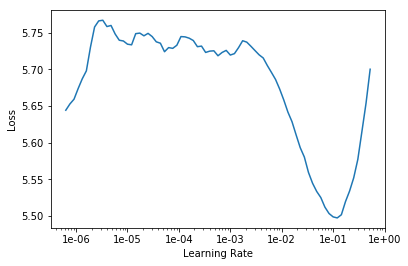

In [105]:
learn.recorder.plot(skip_end=15)

In [110]:
learn.fit_one_cycle(3, 1e-2, moms=(0.8,0.7)) # 1e-2 works fair enough as usual
# theoretically you keep training for as long as the loss keeps decreasing...
# the accuracy's [or any other metric] calcualtion is done to show where your model stands after that epoch
#  overfitting udnerfitting is a concern.. when you are doing a lot of epochs.. for a few epochs go by the above

epoch,train_loss,valid_loss,accuracy,time
0,4.385291,4.233065,0.270084,09:48
1,4.544013,4.118543,0.278826,09:40
2,4.285003,4.020329,0.292102,09:39


For a language model the accuracy being low is fine..

In [0]:
learn.save('fit_head') # fit_head nomenclature: etymology: because we trained only for th last layer.. head of the model...?maybe so

In [0]:
learn.load('fit_head');

In [0]:
learn.unfreeze() # unfreeze all layers to compete the training of full model

In [114]:
learn.fit_one_cycle(6, 1e-3, moms=(0.8,0.7)) # originally 10 cycles but we dont have time :)

epoch,train_loss,valid_loss,accuracy,time
0,3.791799,3.842836,0.317264,10:53
1,3.743700,3.821657,0.326245,10:53
2,3.570505,3.724357,0.342541,10:58
3,3.482038,3.674882,0.351830,11:00
4,3.350525,3.643360,0.357335,11:01
5,3.077419,3.649883,0.357677,11:02


In [0]:
learn.fit_one_cycle(2, 1e-3, moms=(0.8,0.7)) # lets do two more because we are feeling generous :P

In [0]:
learn.save('fine_tuned') # save # stop gap

In [0]:
learn.load('fine_tuned');

In [0]:
TEXT = "and today"
N_WORDS = 40
N_SENTENCES = 2 # test how good the model is at predicting the next few words

In [119]:
print("\n".join(learn.predict(TEXT, N_WORDS, temperature=0.75) for _ in range(N_SENTENCES)))

and today they 're in the process of iraqi control over the 
  Fbi and other criminals . 
 
  The Fbi , who are now going to be there , will be the 
  FBI 's .
and today i got a very good news message which developed a 
  simple way to make the Clipper algorithm work , but it ca n't 
  be easily realized by anyone . i have n't heard of any decent 
 


In [0]:
learn.save_encoder('fine_tuned_enc') # we need the encoder in particular.. not exactly the model that predicts next word

### The Actual Classifier

In [0]:
# Classifier model data
data_clas = TextClasDataBunch.from_df(path = path_d, train_df = df_trn, valid_df = df_val, vocab=data_lm.train_ds.vocab, bs=bs)

In [0]:
learn = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=0.5) # the actual classifier

In [123]:
learn.load_encoder('fine_tuned_enc')

RNNLearner(data=TextClasDataBunch;

Train: LabelList (6788 items)
x: TextList
xxbos 
 
  xxup cnn just claimed he bought 104 " semi - automatic assault rifles " . xxmaj and 
  they say xxmaj koresh was n't god - like ... xxmaj he managed to buy or build a 
  collection of fully - automatic semi - automatic rifles ... xxmaj quite a feat , 
  i would say . ;-) 
 
  xxmaj they 're still making charges of " sexual abuse " and such , or course . 
  xxmaj nobody seems to have noticed that the xxmaj treasury department has nothing 
  to do with sex crimes . xxmaj or maybe the feds have recently instituted a 
  xxup tax on sex crimes ... xxmaj yeah , that 's why the xxup batf was there , looking for 
  unregistered * guns * ( " this is my weapon , this is my gun , this is for 
  fighting , this is for ... " ) . 
 
 
  i also heard that they 're claiming to be cautious because of xxmaj koresh 's 
  " heated ammunition stockpile " . i seem to recall that smokeless powder 
  tends to decompose at

In [124]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


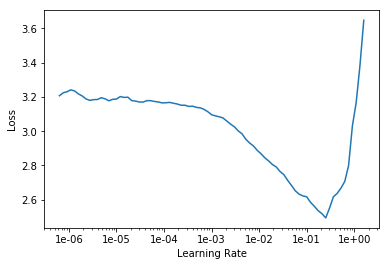

In [125]:
learn.recorder.plot()

In [126]:
#list(range(1e-2,1e-1,10)) # range does only int
import numpy as np
for i in np.arange(1e-2,1e-1,1e-2):
  print(i);

0.01
0.02
0.03
0.04
0.05
0.060000000000000005
0.06999999999999999
0.08
0.09


In [127]:
learn.fit_one_cycle(1, 5e-2, moms=(0.8,0.7)) #was 1e-2 updated based on graph above

epoch,train_loss,valid_loss,accuracy,time
0,1.446844,1.233551,0.610031,07:29


In [0]:
learn.save('first')

In [0]:
learn.load('first'); # save and load the state where the last layer alone is what has been retrained..

In [130]:
slice(1e-2/(2.6**4),1e-2) # refer lecture for how that 2.6**4 was arrived at... apparently its emperically arrived at

slice(0.00021882987290360977, 0.01, None)

In [131]:
from fastai.utils.show_install import show_install
show_install(1)



```text
=== Software === 
python        : 3.6.8
fastai        : 1.0.58
fastprogress  : 0.1.21
torch         : 1.3.0+cu100
nvidia driver : 418.67
torch cuda    : 10.0.130 / is available
torch cudnn   : 7603 / is enabled

=== Hardware === 
nvidia gpus   : 1
torch devices : 1
  - gpu0      : 11441MB | Tesla K80

=== Environment === 
platform      : Linux-4.14.137+-x86_64-with-Ubuntu-18.04-bionic
distro        : #1 SMP Thu Aug 8 02:47:02 PDT 2019
conda env     : Unknown
python        : /usr/bin/python3
sys.path      : 
/env/python
/usr/lib/python36.zip
/usr/lib/python3.6
/usr/lib/python3.6/lib-dynload
/usr/local/lib/python3.6/dist-packages
/usr/lib/python3/dist-packages
/usr/local/lib/python3.6/dist-packages/IPython/extensions
/root/.ipython

Sun Oct 20 16:12:56 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 430.40       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+-

In [0]:
# https://github.com/fastai/fastai/issues/1383

In [0]:
learn.freeze_to(-2) # unfreeze all but last 2 layers
#learn.fit_one_cycle(2, 1e-2, moms=(0.8,0.7))# and then train them
# BLUNDER : you do not train them at the same rate
# instead you train them using a much lower RL as below 
# if you use the same lr as in above case.. accuracy drops .. loss explodes
# good that there was a back up


In [133]:
learn.fit_one_cycle(1, slice(1e-2/(2.6**4),1e-2), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,1.421653,1.141120,0.635440,07:58


In [0]:
# https://forums.fast.ai/t/continue-training-an-already-trained-model/34790
# learn.fit_one_cycle(2, 1e-2) # Another 2 cycles
# with ls of 5e-2 the val loss explodes.. and accuracy drops...
# the comment above is not exactly true... the loss exploded.. because the lr was not reduced.. as seen in the cell above

In [0]:
learn.save('second')

In [0]:
learn.load('second');

In [137]:
learn.freeze_to(-3)
learn.fit_one_cycle(1, slice(5e-3/(2.6**4),5e-3), moms=(0.8,0.7)) # almost half an order lower in range this time

epoch,train_loss,valid_loss,accuracy,time
0,1.189231,1.069476,0.667256,09:14


In [0]:
learn.save('third')# some other steps.. and possibly a callback

In [139]:
learn.load('third')

RNNLearner(data=TextClasDataBunch;

Train: LabelList (6788 items)
x: TextList
xxbos 
 
  xxup cnn just claimed he bought 104 " semi - automatic assault rifles " . xxmaj and 
  they say xxmaj koresh was n't god - like ... xxmaj he managed to buy or build a 
  collection of fully - automatic semi - automatic rifles ... xxmaj quite a feat , 
  i would say . ;-) 
 
  xxmaj they 're still making charges of " sexual abuse " and such , or course . 
  xxmaj nobody seems to have noticed that the xxmaj treasury department has nothing 
  to do with sex crimes . xxmaj or maybe the feds have recently instituted a 
  xxup tax on sex crimes ... xxmaj yeah , that 's why the xxup batf was there , looking for 
  unregistered * guns * ( " this is my weapon , this is my gun , this is for 
  fighting , this is for ... " ) . 
 
 
  i also heard that they 're claiming to be cautious because of xxmaj koresh 's 
  " heated ammunition stockpile " . i seem to recall that smokeless powder 
  tends to decompose at

In [140]:
learn.unfreeze() # unfreze all
learn.fit_one_cycle(2, slice(1e-3/(2.6**4),1e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.943186,1.033650,0.674547,11:37
1,0.779844,1.019502,0.684048,12:11


In [0]:
learn.save('unfreeze_all')

In [0]:
learn.load('unfreeze_all')

In [0]:
# 60-> 67% improvement in accuracy

In [0]:
# next steps 
# learn deeper at the LM stage.. and the classifier model too 10 cycles see its effect on the  percentage above
# throw in a pd.cross tab for a confusion matrix
# and possibly a rank n accuracy matric

In [0]:
preds, targets = learn.get_preds()

In [144]:
predictions = np.argmax(preds, axis = 1)
pd.crosstab(predictions, targets)

col_0,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
row_0,,,,,,,,,,,,,,,,,,,,
0,97,2,0,1,0,0,0,0,3,1,2,2,0,5,4,13,3,10,14,31
1,0,147,16,11,9,27,2,0,2,1,1,4,9,5,6,2,0,0,2,0
2,0,24,160,27,9,9,4,1,1,0,1,6,4,0,4,0,2,0,0,0
3,0,10,22,130,20,2,10,0,0,0,0,1,13,0,0,0,0,1,0,0
4,0,4,9,28,159,4,6,3,0,2,0,2,11,0,3,0,0,1,0,0
5,0,9,8,0,2,181,2,0,0,0,0,4,0,0,0,1,0,2,0,0
6,0,5,1,5,3,2,177,6,5,2,1,2,10,1,1,2,3,1,0,0
7,1,0,1,2,3,0,6,163,25,2,2,1,10,1,4,0,4,0,2,3
8,12,4,2,8,2,1,7,25,179,7,3,4,5,7,9,1,12,3,7,6


In [0]:
#np.mean(predictions==targets)